# Experiments CNN and HAM10000

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

2024-07-20 15:18:36.814164: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 15:18:37.101118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 15:18:37.804924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Data Load

In [2]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [3]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create Image Generator

In [4]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [5]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 1563 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.


In [6]:
train_df["labels"].unique()

array(['0', '1'], dtype=object)

In [7]:
valid_df["labels"].unique()

array(['1', '0'], dtype=object)

## Training

In [8]:
import torch # Due to keras version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[300, 300, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid", kernel_initializer="glorot_uniform", name="classifier"))
        
model.compile(Adam(learning_rate= 0.0001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

2024-07-20 15:18:39.464558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 15:18:39.467991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 15:18:39.468019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 15:18:39.470450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 15:18:39.470475: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,607,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,886,273 (22.45 MB)

 Trainable params: 5,885,761 (22.45 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8307 - loss: 0.4007 - val_accuracy: 0.7786 - val_loss: 0.4665
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8377 - loss: 0.3702 - val_accuracy: 0.7569 - val_loss: 0.4903
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.8382 - loss: 0.3651 - val_accuracy: 0.7754 - val_loss: 0.4929
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8303 - loss: 0.3929 - val_accuracy: 0.7742 - val_loss: 0.4827
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8446 - loss: 0.3473 - val_accuracy: 0.7959 - val_loss: 0.4447
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.8279 - loss: 0.3784 - val_accuracy: 0.7914 - val_loss: 0.4746
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.8314 - loss: 0.3803 - val_accuracy: 0.7953 - val_loss: 0.4851
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8519 - loss: 0.3562 - 

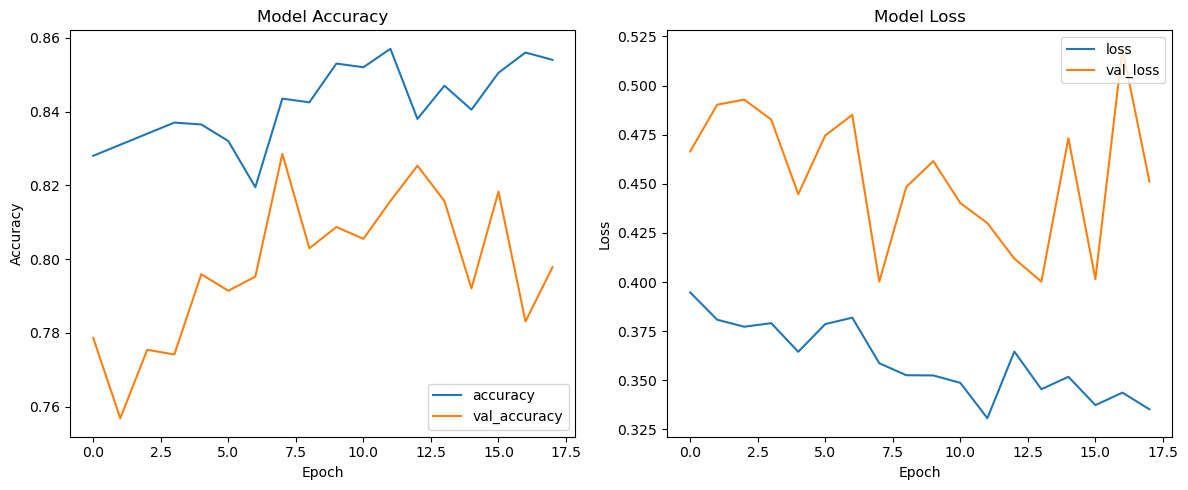

In [27]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [28]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8358 - loss: 0.3620
Test Loss 0.38469383120536804
Test Accuracy 0.8292838931083679


In [29]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1341
           1       0.44      0.74      0.55       223

    accuracy                           0.83      1564
   macro avg       0.70      0.79      0.72      1564
weighted avg       0.88      0.83      0.85      1564



# Adversarial Attacks

## Random Noise

True label: 0
Prediction: [[0.2776109]]
Prediction class: ['0']
Adversarial Prediction: [[0.0933421]]
Adversarial Predicted Class: ['0']


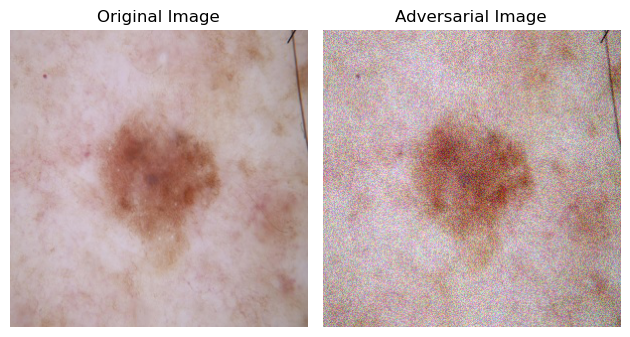

In [53]:
np.random.seed(42)
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.15
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [54]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [55]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.4085677749360614
RN TN Success rate: 0.3881074168797954
RN FP Success rate: 0.020460358056265986


## FGSM

True label: 1
Prediction: [[0.9264712]]
Prediction class: ['1']
Adversarial Prediction: [[0.00340549]]
Adversarial Predicted Class: ['0']


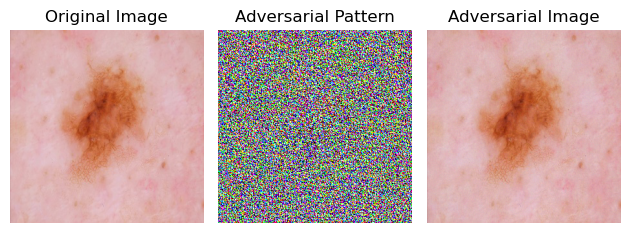

In [33]:
filepath = f"{root}data/ISIC_0026105.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.01
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [34]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [35]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.8107416879795396
FGSM TN Success rate: 0.7052429667519181
FGSM FP Success rate: 0.10549872122762148


## Saliency Map Attack

True label: 0
Prediction: [[0.2776109]]
Prediction class: ['0']
Adversarial Prediction: [[0.00237714]]
Adversarial Predicted Class: ['0']


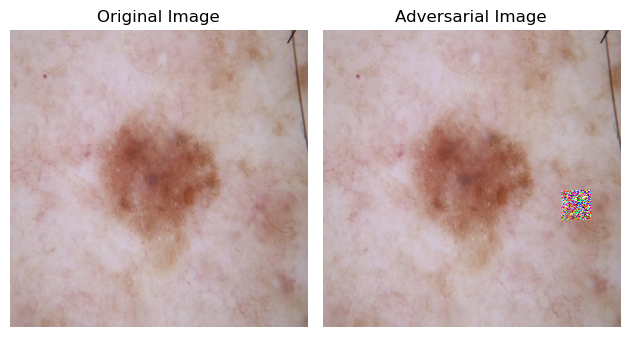

In [68]:
# filepath = f"{root}data/ISIC_0026105.jpg"
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.7
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [69]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [70]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.3350383631713555
SM TN Success rate: 0.3075447570332481
SM FP Success rate: 0.027493606138107418


## Data export for analysis

In [71]:
test_df.to_csv(f"{root}exp/test_df_HAM10000_CNN.csv", index=False)